<a href="https://colab.research.google.com/github/Judy-Choi/Tensorflow_Certificate/blob/main/12_sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal Metric
- val_loss : 0.3626
- val_acc : 0.8372

# Goal Metric (val_loss : 0.3626)
- val_loss : 0.3626
- val_acc : 0.8372

## sarcasm 은 Huffpost의 헤드라인 중에서 비꼬는 타이틀과 그렇지 않은 타이틀을 구분하는데 있다..

In [ ]:
import json
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten, Bidirectional, LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 1. 데이터 준비하기

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x7f0857c6ac40>)

### json 파일 로드

In [ ]:
with open('sarcasm.json') as f:
    data = json.load(f)

### json 으로 로드한 데이터는 array of dictionaries 

In [ ]:
data[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

### 각 헤드라인의 문장(sentences)과 sarcasm 인지 아닌지를 나타내는 답(labels)으로 나누기

In [ ]:
data[3]['headline']

'boehner just wants wife to listen, not come up with alternative debt-reduction ideas'

In [ ]:
data[3]['is_sarcastic']

1

In [ ]:
# 전체 sentense의 수
len(data)  

26709

### sentenses 와 labels 로 나누려면, list 를 사용해서, 하나씩 list.append() 한다

In [ ]:
sentences = []
labels = []
for d in data:
    sentences.append(d['headline'])
    labels.append(d['is_sarcastic'])

In [ ]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [ ]:
len(sentences)

26709

In [ ]:
labels[:5]

[0, 0, 1, 1, 0]

### train / test 세트 나누기

In [ ]:
# 주어지는 값. 전체 데이터셋을 앞에서 20000개는 training으로 나머지는 test로 사용하기 위해서 나눈다
training_size = 20000

In [ ]:
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

In [ ]:
test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

### 토큰화의 첫단계: Tokenizer 정의

* `num_words`: 단어 max 사이즈를 지정합니다. 가장 빈도수가 높은 단어부터 저장합니다.
* `oov_token`: 단어 토큰에 없는 단어를 어떻게 표기할 것인지 지정해줍니다.
* `maxlen`: 최대 문장 길이를 정의합니다. 최대 문장길이보다 길면, 잘라냅니다.
* `truncating`: 문장의 길이가 `maxlen`보다 길 때 앞을 자를지 뒤를 자를지 정의합니다.
* `padding`: 문장의 길이가 `maxlen`보다 짧을 때 채워줄 값을 앞을 채울지, 뒤를 채울지 정의합니다.

In [ ]:
# vocab_size 는 전체 unique한 단어의 수에 맞추는 것이 좋다
vocab_size = 1000  # 25637
# oov = out of vacabulary
oov_tok = "<oov>"  

# max_length 헤드라인에 들어가는 최대 단어수를 정한다.
max_length = 120

trunc_type='post'
padding_type='post'

embedding_dim = 16   # word2vec

단어의 토큰화를 진행합니다.

* `num_words`: 단어 max 사이즈를 지정합니다. 가장 빈도수가 높은 단어부터 저장합니다.
* `oov_token`: 단어 토큰에 없는 단어를 어떻게 표기할 것인지 지정해줍니다.

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

## Tokenizer로 학습시킬 문장에 대한 토큰화 진행

In [ ]:
tokenizer.fit_on_texts(train_sentences)

In [ ]:
tokenizer.word_index

{'<oov>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'by': 19,
 'this': 20,
 'after': 21,
 'be': 22,
 'up': 23,
 'out': 24,
 'that': 25,
 'how': 26,
 'as': 27,
 'it': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'what': 32,
 'his': 33,
 'all': 34,
 'he': 35,
 'will': 36,
 'who': 37,
 'just': 38,
 'has': 39,
 'more': 40,
 'one': 41,
 'year': 42,
 'into': 43,
 'report': 44,
 'have': 45,
 'why': 46,
 'over': 47,
 'area': 48,
 'u': 49,
 'donald': 50,
 'says': 51,
 'day': 52,
 'can': 53,
 's': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'get': 59,
 'old': 60,
 'no': 61,
 'her': 62,
 "trump's": 63,
 'off': 64,
 'now': 65,
 'an': 66,
 'obama': 67,
 'life': 68,
 'people': 69,
 'women': 70,
 'house': 71,
 "'": 72,
 'was': 73,
 'still': 74,
 'white': 75,
 'back': 76,
 'make': 77,
 'than': 78,
 'clinton': 79,
 'down': 80,
 'when': 8

In [ ]:
len(tokenizer.word_index)   # 전체 row size 26709 = 20000 + 6709 

25637

In [ ]:
word_index = tokenizer.word_index

In [ ]:
word_index['hi']

13894

In [ ]:
word_index['<oov>']

1

### 문장(sentences)을 토큰으로 변경 (수치형으로 변경) - texts_to_sequences

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
train_sequences[:5]

[[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1],
 [4, 1, 1, 1, 23, 2, 161, 1, 390, 1, 6, 251, 9, 889],
 [153, 890, 2, 891, 1, 1, 595, 1, 221, 133, 36, 45, 2, 1],
 [1, 38, 213, 382, 2, 1, 29, 288, 23, 10, 1, 1, 1, 958],
 [715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]]

In [ ]:
word_index['j'], word_index['k'], word_index['rowling'], word_index['wishes'], word_index['snape'], word_index['happy']

(715, 672, 5652, 1043, 8865, 662)

### test 문장에도 `Tokenizer`를 적용합니다.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)

### 시퀀스의 길이를 맞춰주기 (pad_sequences)

3가지 옵션을 입력해 줍니다.

* `maxlen`: 최대 문장 길이를 정의합니다. 최대 문장길이보다 길면, 잘라냅니다.
* `truncating`: 문장의 길이가 `maxlen`보다 길 때 앞을 자를지 뒤를 자를지 정의합니다.
* `padding`: 문장의 길이가 `maxlen`보다 짧을 때 채워줄 값을 앞을 채울지, 뒤를 채울지 정의합니다.

In [ ]:
x_train = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)

In [ ]:
x_train.shape

(20000, 120)

In [ ]:
x_train[0]

array([328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [ ]:
x_test = pad_sequences(test_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)

In [ ]:
x_test.shape

(6709, 120)

In [ ]:
x_test[0]

array([  1,   1,   1,   1,  30,   1,   1,   5, 519, 109,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

### Label 값을 Numpy Array로 변환

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
y_train[0], y_test[0]

(0, 1)

##4. 모델설계하기
###Embedding Layer

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Flatten(),
    Dense(32, activation='relu'),
    # YOUR CODE HERE. KEEP THIS OUTPUT LAYER INTACT OR TESTS MAY FAIL
    Dense(1, activation='sigmoid')
    ])

### optimizer, loss 정의

`loss`는 이진 분류이기 때문에 `binary_crossentropy`를 사용하고, optimizer는 `adam`을 사용합니다.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##6. 모델 모니터링하기(체크포인트 생성)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
    save_weights_only=True, 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1)

##5. 모델 학습하기 - 0.36931


In [ ]:
history = model.fit(x_train, y_train, 
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, early_stopping],
    epochs=50)

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.7717
Epoch 1: val_loss improved from inf to 0.38991, saving model to my_checkpoint.ckpt
625/625 [==============================] - 48s 53ms/step - loss: 0.4545 - accuracy: 0.7717 - val_loss: 0.3899 - val_accuracy: 0.8193
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8394
Epoch 2: val_loss improved from 0.38991 to 0.37284, saving model to my_checkpoint.ckpt
625/625 [==============================] - 18s 29ms/step - loss: 0.3540 - accuracy: 0.8394 - val_loss: 0.3728 - val_accuracy: 0.8316
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8559
Epoch 3: val_loss improved from 0.37284 to 0.36931, saving model to my_checkpoint.ckpt
625/625 [==============================] - 19s 31ms/step - loss: 0.3247 - accuracy: 0.8559 - val_loss: 0.3693 - val_accuracy: 0.8323
Epoch 4/50
624/625 [============================>.] - ET

In [ ]:
model.load_weights(checkpoint_path)
model.save("sarcasm.h5")

##7. 모델 검증하기

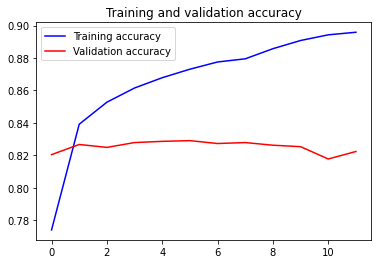

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

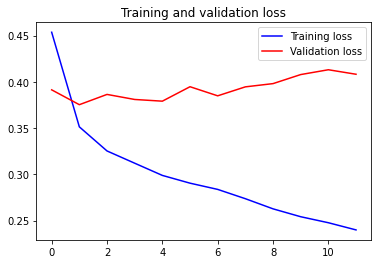

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

### 모델 저장하기

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(x_train[0]))
print(train_sentences[2])
print(labels[2])

former <oov> store <oov> <oov> over secret <oov> <oov> for <oov> <oov> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
model.load_weights(checkpoint_path)
model.save("sarcasm.h5")

# visualize word2vec using google embedding projector

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[88], [], [1], [1], [7], [1], [1], [1], [], [632], [1], [88], [1], [672], [], [632], [1], [88], [54], [], [88], [54], [], [7], [1], [7], [1], [88], [1], [1], [], [], [1], [1], [1], [1], [54], [632], []]


# Homework 1 : Bidirectional

## 1-1. LSTM - 0.37946

In [1]:
# ======================================================================
# There are 5 questions in this test with increasing difficulty from 1-5
# Please note that the weight of the grade for the question is relative
# to its difficulty. So your Category 1 question will score much less
# than your Category 5 question.
# ======================================================================
#
# NLP QUESTION
#
# For this task you will build a classifier for the sarcasm dataset
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown
# It will be tested against a number of sentences that the network hasn't previously seen
# And you will be scored on whether sarcasm was correctly detected in those sentences

import json
import tensorflow as tf
import numpy as np
import urllib

# import libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten, Bidirectional, LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def solution_model():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
    urllib.request.urlretrieve(url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_size = 20000
    
    sentences = []
    labels = []
    # YOUR CODE HERE
    
    # json file load
    with open('sarcasm.json') as f:
        data = json.load(f)
    
    # Sentence 와 Label 로 나누기
    for d in data:
        sentences.append(d['headline'])
        labels.append(d['is_sarcastic'])
        
    # 주어지는 값. 전체 데이터셋을 앞에서 20000개는 training으로 나머지는 test로 사용하기 위해서 나눈다
    train_sentences = sentences[:training_size]
    train_labels = labels[:training_size]
    test_sentences = sentences[training_size:]
    test_labels = labels[training_size:]
    
    # Tokenizer 정의
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    
    # 문자 데이터를 입력받아서 리스트의 형태로 변환
    # = 공백 기준으로 토크나이징
    # vocab 생성
    tokenizer.fit_on_texts(train_sentences)
    
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    # = 문장 -> 토큰 -> indexing
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    
    # 문장 길이 맞추기 (padding)
    x_train = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    x_test = pad_sequences(test_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    
    # Label 값을 Numpy Array로 변환
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    
    model = tf.keras.Sequential([
    # YOUR CODE HERE. KEEP THIS OUTPUT LAYER INTACT OR TESTS MAY FAIL
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Flatten(),
        Dense(32, activation='relu'),
    
        tf.keras.layers.Dense(1, activation='sigmoid')
        
    ])
    
    # optimizer, loss 정의
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_path = 'my_checkpoint.ckpt'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
        save_weights_only=True, 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1)
    
    # Train
    history = model.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, early_stopping],
        epochs=50)
    
    return model


# Note that you'll need to save your model as a .h5 like this
# This .h5 will be uploaded to the testing infrastructure
# and a score will be returned to you
if __name__ == '__main__':
    model = solution_model()
    model.save("mymodel.h5")


Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.7816
Epoch 1: val_loss improved from inf to 0.39326, saving model to my_checkpoint.ckpt
625/625 [==============================] - 64s 64ms/step - loss: 0.4409 - accuracy: 0.7816 - val_loss: 0.3933 - val_accuracy: 0.8159
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8385
Epoch 2: val_loss improved from 0.39326 to 0.37946, saving model to my_checkpoint.ckpt
625/625 [==============================] - 27s 44ms/step - loss: 0.3532 - accuracy: 0.8385 - val_loss: 0.3795 - val_accuracy: 0.8287
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8549
Epoch 3: val_loss did not improve from 0.37946
625/625 [==============================] - 23s 37ms/step - loss: 0.3260 - accuracy: 0.8549 - val_loss: 0.3847 - val_accuracy: 0.8269
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8658


## 1-2. GRU - 0.37173

In [15]:
# ======================================================================
# There are 5 questions in this test with increasing difficulty from 1-5
# Please note that the weight of the grade for the question is relative
# to its difficulty. So your Category 1 question will score much less
# than your Category 5 question.
# ======================================================================
#
# NLP QUESTION
#
# For this task you will build a classifier for the sarcasm dataset
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown
# It will be tested against a number of sentences that the network hasn't previously seen
# And you will be scored on whether sarcasm was correctly detected in those sentences

import json
import tensorflow as tf
import numpy as np
import urllib

# import libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten, Bidirectional, GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def solution_model():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
    urllib.request.urlretrieve(url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_size = 20000
    
    sentences = []
    labels = []
    # YOUR CODE HERE
    
    # json file load
    with open('sarcasm.json') as f:
        data = json.load(f)
    
    # Sentence 와 Label 로 나누기
    for d in data:
        sentences.append(d['headline'])
        labels.append(d['is_sarcastic'])
        
    # 주어지는 값. 전체 데이터셋을 앞에서 20000개는 training으로 나머지는 test로 사용하기 위해서 나눈다
    train_sentences = sentences[:training_size]
    train_labels = labels[:training_size]
    test_sentences = sentences[training_size:]
    test_labels = labels[training_size:]
    
    # Tokenizer 정의
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    
    # 문자 데이터를 입력받아서 리스트의 형태로 변환
    # = 공백 기준으로 토크나이징
    # vocab 생성
    tokenizer.fit_on_texts(train_sentences)
    
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    # = 문장 -> 토큰 -> indexing
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    
    # 문장 길이 맞추기 (padding)
    x_train = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    x_test = pad_sequences(test_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    
    # Label 값을 Numpy Array로 변환
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    
    from transformers import TFRobertaForSequenceClassification

    roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

    model = tf.keras.Sequential([
        roberta_model,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    
    # optimizer, loss 정의
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_path = 'my_checkpoint.ckpt'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
        save_weights_only=True, 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1)
    
    # Train
    history = model.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, early_stopping],
        epochs=50)
    
    return model


# Note that you'll need to save your model as a .h5 like this
# This .h5 will be uploaded to the testing infrastructure
# and a score will be returned to you
if __name__ == '__main__':
    model = solution_model()
    model.save("mymodel.h5")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50


TypeError: ignored

# Homework 2 : Transfer Learning(RoBERTa) - ERROR!

업계에서 BERT 보다 널리 쓰이는 RoBERTa 로 Transfer Learning 시도

In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 23.3 MB/s eta 0:00:00


In [18]:
# ======================================================================
# There are 5 questions in this test with increasing difficulty from 1-5
# Please note that the weight of the grade for the question is relative
# to its difficulty. So your Category 1 question will score much less
# than your Category 5 question.
# ======================================================================
#
# NLP QUESTION
#
# For this task you will build a classifier for the sarcasm dataset
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown
# It will be tested against a number of sentences that the network hasn't previously seen
# And you will be scored on whether sarcasm was correctly detected in those sentences

import json
import tensorflow as tf
import numpy as np
import urllib

# import libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten, Bidirectional, LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from transformers import TFRobertaModel


def solution_model():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
    urllib.request.urlretrieve(url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_size = 20000
    
    sentences = []
    labels = []
    # YOUR CODE HERE
    
    # json file load
    with open('sarcasm.json') as f:
        data = json.load(f)
    
    # Sentence 와 Label 로 나누기
    for d in data:
        sentences.append(d['headline'])
        labels.append(d['is_sarcastic'])
        
    # 주어지는 값. 전체 데이터셋을 앞에서 20000개는 training으로 나머지는 test로 사용하기 위해서 나눈다
    train_sentences = sentences[:training_size]
    train_labels = labels[:training_size]
    test_sentences = sentences[training_size:]
    test_labels = labels[training_size:]
    
    # Tokenizer 정의
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    
    # 문자 데이터를 입력받아서 리스트의 형태로 변환
    # = 공백 기준으로 토크나이징
    # vocab 생성
    tokenizer.fit_on_texts(train_sentences)
    
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    # = 문장 -> 토큰 -> indexing
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    
    # 문장 길이 맞추기 (padding)
    x_train = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    x_test = pad_sequences(test_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    
    # Label 값을 Numpy Array로 변환
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)

    roberta_model = TFRobertaModel.from_pretrained('roberta-base')

    model = Sequential([
        roberta_model,
        Dropout(0.2),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    # optimizer, loss 정의
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_path = 'my_checkpoint.ckpt'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
        save_weights_only=True, 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1)
    
    # Train
    history = model.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, early_stopping],
        epochs=50)
    
    return model


# Note that you'll need to save your model as a .h5 like this
# This .h5 will be uploaded to the testing infrastructure
# and a score will be returned to you
if __name__ == '__main__':
    model = solution_model()
    model.save("mymodel.h5")


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


ValueError: ignored

# Homework 3. ChatGPT

## 3-1. Bidirectional - 0.37531
다음 코드를 최적화해 줘,  
단, 다음 조건을 적용해 줘  
Use dropout  
Use batch normalization  
Use checkpoint with save best only, and save weight only   and verbose = 1  
Use early stopping with patience = 10  
Use reduce learning rate on plateau  
set verbose = 1  
Set epochs = 50  
do not use data augmentation  
Use other methods to make val loss value lower.  


ChatGPT Answer:

주요 변경 사항:
- Dropout layer와 BatchNormalization layer 추가
- ReduceLROnPlateau callback 추가
- Adam optimizer의 learning rate 조정
- 모델 구성 코드를 좀 더 가독성 있게 수정

In [16]:
# ======================================================================
# There are 5 questions in this test with increasing difficulty from 1-5
# Please note that the weight of the grade for the question is relative
# to its difficulty. So your Category 1 question will score much less
# than your Category 5 question.
# ======================================================================
#
# NLP QUESTION
#
# For this task you will build a classifier for the sarcasm dataset
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown
# It will be tested against a number of sentences that the network hasn't previously seen
# And you will be scored on whether sarcasm was correctly detected in those sentences

import json
import tensorflow as tf
import numpy as np
import urllib

# import libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


def solution_model():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
    urllib.request.urlretrieve(url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_size = 20000
    
    sentences = []
    labels = []
    # YOUR CODE HERE
    
    # json file load
    with open('sarcasm.json') as f:
        data = json.load(f)
    
    # Sentence 와 Label 로 나누기
    for d in data:
        sentences.append(d['headline'])
        labels.append(d['is_sarcastic'])
        
    # 주어지는 값. 전체 데이터셋을 앞에서 20000개는 training으로 나머지는 test로 사용하기 위해서 나눈다
    train_sentences = sentences[:training_size]
    train_labels = labels[:training_size]
    test_sentences = sentences[training_size:]
    test_labels = labels[training_size:]
    
    # Tokenizer 정의
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    
    # 문자 데이터를 입력받아서 리스트의 형태로 변환
    # = 공백 기준으로 토크나이징
    # vocab 생성
    tokenizer.fit_on_texts(train_sentences)
    
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    # = 문장 -> 토큰 -> indexing
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    
    # 문장 길이 맞추기 (padding)
    x_train = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    x_test = pad_sequences(test_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    
    # Label 값을 Numpy Array로 변환
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    
    # Define the model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        BatchNormalization(),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_path = 'my_checkpoint.ckpt'
    checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

    # Fit the model
    history = model.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, checkpoint, reduce_lr],
        epochs=50, verbose=1)
    
    return model


# Note that you'll need to save your model as a .h5 like this
# This .h5 will be uploaded to the testing infrastructure
# and a score will be returned to you
if __name__ == '__main__':
    model = solution_model()
    model.save("mymodel.h5")


Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.7591
Epoch 1: val_loss improved from inf to 0.53683, saving model to my_checkpoint.ckpt
625/625 [==============================] - 49s 58ms/step - loss: 0.4982 - accuracy: 0.7591 - val_loss: 0.5368 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 2/50
624/625 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8242
Epoch 2: val_loss did not improve from 0.53683
625/625 [==============================] - 24s 38ms/step - loss: 0.3851 - accuracy: 0.8243 - val_loss: 0.7870 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 0.3527 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.53683 to 0.37531, saving model to my_checkpoint.ckpt
625/625 [==============================] - 24s 38ms/step - loss: 0.3527 - accuracy: 0.8453 - val_loss: 0.3753 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 4/50
624/625 [============================>.] - ETA

## 3-2. Transfer Learning - ERROR!
방금 코드의 Bidirectional layer 대신 사전 학습된 자연어 분류 모델을 적용해 줘


ChatGPT Answer:
사전 학습된 자연어 분류 모델을 적용하려면 먼저 해당 모델을 로드해야 합니다. 저는 TensorFlow Hub에서 제공하는 tensorflow_hub.KerasLayer를 사용하여 모델을 로드하겠습니다.

모델은 tensorflow_hub.KerasLayer를 사용하여 로드되며, 이후에는 나머지 부분을 그대로 유지하면 됩니다. 다음은 코드 예시입니다.

위의 코드에서는 먼저 hub.KerasLayer를 사용하여 사전 학습된 모델을 로드하고, 이후에는 새로운 모델을 정의합니다. 이 모델은 hub.KerasLayer를 첫 번째 레이어로 사용하고, 이후에는 Dropout, BatchNormalization, Dense 레이어를 추가합니다. 최종 출력 레이어는 1차원 Dense 레이어로 이진 분류 문제를 해결합니다.

모델을 컴파일하고, 콜백 함수를 설정한 후 fit 메서드를 사용하여 모델을 학습합니다.

In [17]:
# ======================================================================
# There are 5 questions in this test with increasing difficulty from 1-5
# Please note that the weight of the grade for the question is relative
# to its difficulty. So your Category 1 question will score much less
# than your Category 5 question.
# ======================================================================
#
# NLP QUESTION
#
# For this task you will build a classifier for the sarcasm dataset
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown
# It will be tested against a number of sentences that the network hasn't previously seen
# And you will be scored on whether sarcasm was correctly detected in those sentences

import json
import tensorflow as tf
import numpy as np
import urllib

# import libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import tensorflow_hub as hub

def solution_model():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
    urllib.request.urlretrieve(url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_size = 20000
    
    sentences = []
    labels = []
    # YOUR CODE HERE
    
    # json file load
    with open('sarcasm.json') as f:
        data = json.load(f)
    
    # Sentence 와 Label 로 나누기
    for d in data:
        sentences.append(d['headline'])
        labels.append(d['is_sarcastic'])
        
    # 주어지는 값. 전체 데이터셋을 앞에서 20000개는 training으로 나머지는 test로 사용하기 위해서 나눈다
    train_sentences = sentences[:training_size]
    train_labels = labels[:training_size]
    test_sentences = sentences[training_size:]
    test_labels = labels[training_size:]
    
    # Tokenizer 정의
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    
    # 문자 데이터를 입력받아서 리스트의 형태로 변환
    # = 공백 기준으로 토크나이징
    # vocab 생성
    tokenizer.fit_on_texts(train_sentences)
    
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    # = 문장 -> 토큰 -> indexing
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    
    # 문장 길이 맞추기 (padding)
    x_train = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    x_test = pad_sequences(test_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    
    # Label 값을 Numpy Array로 변환
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    

    # Pretrained model을 로드합니다
    pretrained_model_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
    hub_layer = hub.KerasLayer(pretrained_model_url, input_shape=[], dtype=tf.string, trainable=True)

   # 새로운 모델을 정의합니다
    model = tf.keras.Sequential([
            hub_layer,
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    
    # optimizer, loss 정의
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_path = 'my_checkpoint.ckpt'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
            save_weights_only=True, 
            save_best_only=True, 
            monitor='val_loss',
            verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

    # Fit the model
    history = model.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, checkpoint, reduce_lr],
        epochs=50, verbose=1)
    
    return model


# Note that you'll need to save your model as a .h5 like this
# This .h5 will be uploaded to the testing infrastructure
# and a score will be returned to you
if __name__ == '__main__':
    model = solution_model()
    model.save("mymodel.h5")


Epoch 1/50


ValueError: ignored